# Computer Vision Project

## Project Statement
The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. You are asked to conduct that evaluation, so as you set to work, keep the following in mind:

- The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol
- Computer vision methods can be used to determine age of a person from a photo
- The task then is to build and evaluate a model for verifying people's age

To start working on the task, you'll have a set of photographs of people with their ages indicated.

## Project Instructions
1) Perform exploratory data analysis to get an overall impression of the dataset.
2) Train and evaluate the model.
3) Make conclusions of the model evaluation

## Initialization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
def load_data(file_name, local_path, server_path):
    try:
        data = pd.read_csv(local_path + file_name)
        print(f"'{file_name}' file successfully read from the local path.")

    except FileNotFoundError:
        try:
            data = pd.read_csv(server_path + file_name)
            print(f"'{file_name}' file successfully read from the server path.")

        except FileNotFoundError:
            print(f"'{file_name}' file not found. Please check the file paths.")
            data = None
            
    return data

file_name = 'labels.csv'
local_path = '/Users/benjaminstephen/Documents/TripleTen/Sprint_15/Computer_Vision_Project/datasets/faces/'
server_path = '/datasets/faces/'

data = load_data(file_name, local_path, server_path) 

'labels.csv' file successfully read from the local path.


## EDA

It is useful to conduct EDA before rushing into modelling, even while working with sophisticated models like neural networks. So, let's have a look at the data for this project.

In [3]:
display(data)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


In [5]:
print("NUMBER OF DUPLICATED ROWS:", data.duplicated().sum())

NUMBER OF DUPLICATED ROWS: 0


The dataframe is clean and well-prepared for exploratory data analysis as it contains no missing values or duplicated rows.

Let's now explore the distribution of age within the dataset.

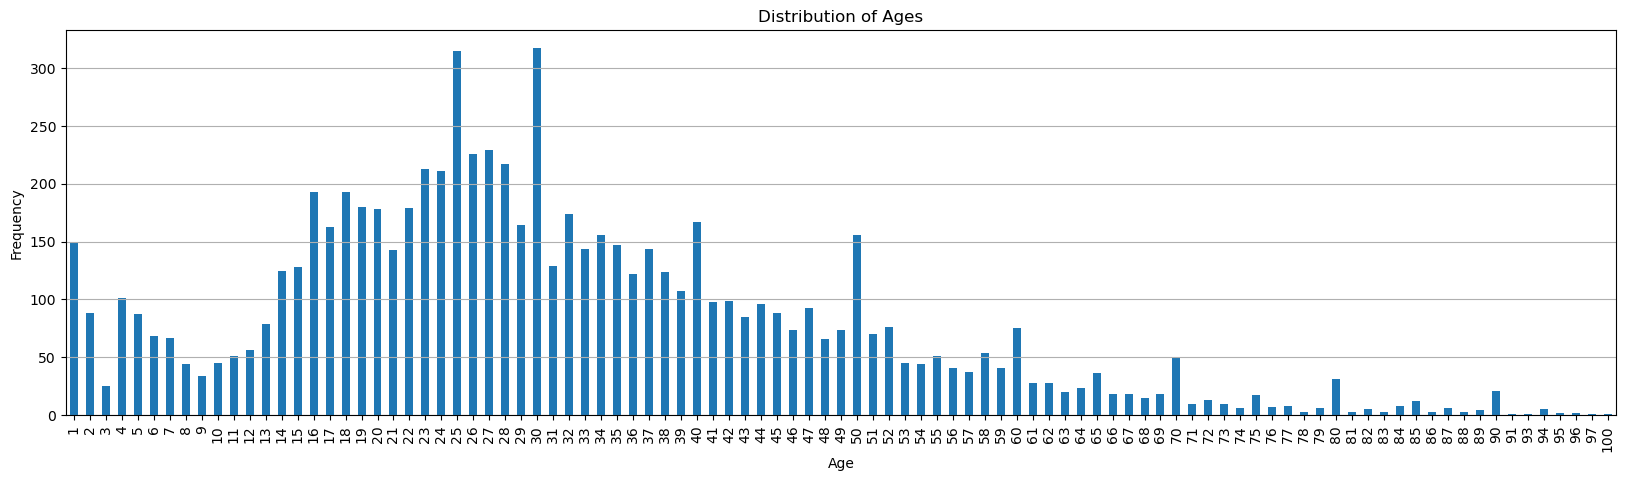

In [6]:
# Group by age and count occurrences
age_counts = data['real_age'].value_counts().sort_index()

# Plot the age distribution
plt.figure(figsize=(20, 5))
age_counts.plot(kind='bar')
plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

As illustrated in the visual above, the peak ages are 24 and 30, with the majority of the distribution concentrated between 20 and 40 years old. Additionally, there is a clear trend showing a decline in the frequency of individuals represented in the dataset as age increases.

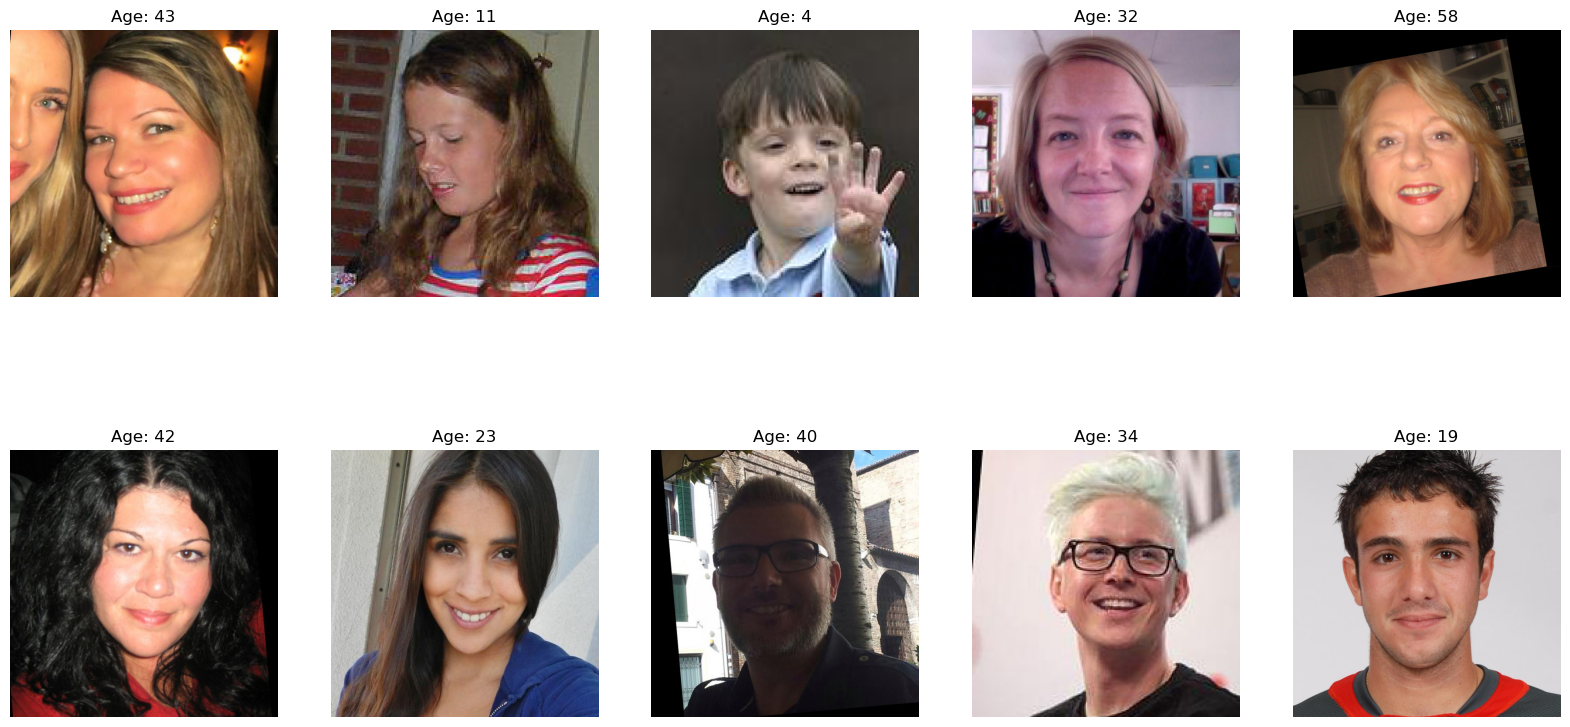

In [7]:
# Select random samples to display
samples = random.sample(range(len(data)), 10)

# Display sampled images
plt.figure(figsize=(20, 10))
for i, index in enumerate(samples, 1):
    try:
        image_path = local_path + 'final_files/' + data.loc[index, 'file_name']
        image = plt.imread(image_path)
    except FileNotFoundError:
        try:
            image_path = server_path + 'final_files/' + data.loc[index, 'file_name']
            image = plt.imread(image_path)
        except FileNotFoundError:
            print(f"'{file_name}' file not found in both local and server paths. Please check the file paths.")
            continue

    plt.subplot(2, 5, i)
    plt.imshow(image)
    plt.title(f"Age: {data.loc[index, 'real_age']}")
    plt.axis('off')

plt.show()

### Findings

The dataset is characterized by a high level of data integrity, as it contains no missing values or duplicate file names. The age distribution is predominantly skewed towards individuals aged 20 to 40, with over twice as many participants over the age of 21 compared to those under 21. This robust representation indicates a significant presence of individuals eligible to purchase alcohol within the dataset.

There are, however, imperfections in the photos might lead to an unacceptably high margin of error for the model. I can mitigate this to some extent using data augmentation. Specifically:

- Horizontal flips. Since customers might slightly angle their faces to the left or right, and the dataset includes such variations, applying horizontal flips can help the model better handle angled faces.

- Zooming in. Some images in the dataset feature faces that are not close enough, making them harder to analyze. I believe zooming in by up to 20% would be a reasonable adjustment.

- Rotation. This will also likely to improve the model's performance. Customers may have their heads tilted at various angles when their photos are taken, so the model needs to account for this. I think rotating images by up to 30°, either clockwise or counterclockwise, would be effective.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [8]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [9]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    df = pd.read_csv(path + '/labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rescale=1.0 / 255, 
                                       vertical_flip=True,
                                       horizontal_flip=True,
                                       rotation_range=90,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2)
    
    train_datagen_flow = datagen.flow_from_dataframe(dataframe=df,
                                                     directory=path + '/final_files',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=16,
                                                     class_mode='raw',
                                                     subset='training',
                                                     seed=12345)
    
    return train_gen_flow

In [10]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """

    df = pd.read_csv(path + '/labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1.0 / 255)
    
    test_datagen_flow = datagen.flow_from_dataframe(dataframe=df,
                                                    directory=path + '/final_files',
                                                    x_col='file_name',
                                                    y_col='real_age',
                                                    target_size=(224, 224),
                                                    batch_size=16,
                                                    class_mode='raw',
                                                    subset='validation',
                                                    seed=12345)

    return test_gen_flow

In [11]:
def create_model(input_shape):
    
    """
    It defines model
    """

    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [12]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [13]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Epoch 1/20

356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921

Epoch 2/20

356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035

Epoch 3/20

356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454

Epoch 4/20

356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481

Epoch 5/20

356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192

Epoch 6/20

356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332

Epoch 7/20

356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359

Epoch 8/20

356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239

Epoch 9/20

356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529

Epoch 10/20

356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629

Epoch 11/20

356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866

Epoch 12/20

356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591

Epoch 13/20

356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467

Epoch 14/20

356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401

Epoch 15/20

356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841

Epoch 16/20

356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304

Epoch 17/20

356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419

Epoch 18/20

356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226

Epoch 19/20

356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908

Epoch 20/20

356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512

## Conclusions

Based on the model's results, several conclusions can be drawn:

Over the course of 20 epochs, the model demonstrates a favorable convergence on the training data, achieving a mean absolute error (MAE) of 3.1. However, there are indications that the model may be experiencing overfitting, as the test MAE exceeds double that of the training MAE. This discrepancy suggests that we may need either more data or a more complex model to improve performance on unseen data.

In practical terms, the model is likely to perform adequately for customers who are significantly older than 21, given that its expected MAE for this group is around 7 to 8 years. However, relying solely on predictions for individuals aged 18 to 28 may be risky, as the same MAE of approximately 7 to 8 years could lead to less accurate predictions for this age range.

# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training